#安裝套件

In [146]:
!pip install yfinance

In [147]:
!pip install mplfinance

#ARIMA

In [166]:
import yfinance as yf # yahoo finance 套件
import pandas as pd # 結構化資料處理套件
import datetime as dt # 時間套件
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools

In [149]:
# 輸入股票代號
stock_id = "2330.tw"

# 資料結束時間
end = dt.date.today()

# 抓取半年資料（現在-過去180天）
start = end - dt.timedelta(days=180)

# 參數1: 股票代號, 參數2: 開始時間, 參數3: 結束時間
data = yf.download(stock_id, start=start, end=end).reset_index()

data

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2024-04-22,740.0,757.0,740.0,742.0,735.861633,46540798
1,2024-04-23,761.0,761.0,752.0,754.0,747.762390,30423647
2,2024-04-24,770.0,785.0,769.0,783.0,776.522461,39457128
3,2024-04-25,770.0,774.0,765.0,766.0,759.663086,28534926
4,2024-04-26,788.0,789.0,782.0,782.0,775.530762,32571247
...,...,...,...,...,...,...,...
115,2024-10-09,1030.0,1035.0,1020.0,1020.0,1020.000000,46975717
116,2024-10-11,1025.0,1050.0,1020.0,1045.0,1045.000000,43058754
117,2024-10-14,1045.0,1055.0,1035.0,1045.0,1045.000000,36858874
118,2024-10-15,1050.0,1075.0,1050.0,1070.0,1070.000000,42850176


In [151]:
arima_data = data.copy()
arima_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2024-04-22,740.0,757.0,740.0,742.0,735.861633,46540798
1,2024-04-23,761.0,761.0,752.0,754.0,747.762390,30423647
2,2024-04-24,770.0,785.0,769.0,783.0,776.522461,39457128
3,2024-04-25,770.0,774.0,765.0,766.0,759.663086,28534926
4,2024-04-26,788.0,789.0,782.0,782.0,775.530762,32571247


In [152]:
# 將日期欄位轉為datetime格式
arima_data['Date'] = pd.to_datetime(arima_data['Date'])

arima_data.set_index('Date', inplace=True)

arima_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-22,740.0,757.0,740.0,742.0,735.861633,46540798
2024-04-23,761.0,761.0,752.0,754.0,747.762390,30423647
2024-04-24,770.0,785.0,769.0,783.0,776.522461,39457128
2024-04-25,770.0,774.0,765.0,766.0,759.663086,28534926
2024-04-26,788.0,789.0,782.0,782.0,775.530762,32571247
...,...,...,...,...,...,...
2024-10-09,1030.0,1035.0,1020.0,1020.0,1020.000000,46975717
2024-10-11,1025.0,1050.0,1020.0,1045.0,1045.000000,43058754
2024-10-14,1045.0,1055.0,1035.0,1045.0,1045.000000,36858874


In [153]:
# 選擇收盤價作為預測目標
close_prices = arima_data['Close']


In [154]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    return result[1]  # 返回 p-value

# 測試是否需要進行差分
p_value = adf_test(close_prices)
if p_value > 0.05:
    print("非平穩，需要差分（d>0）")
else:
    print("平穩，不需要差分（d=0）")


ADF Statistic: -2.046641335396321
p-value: 0.2665040911665042
非平穩，需要差分（d>0）


In [155]:
close_prices_diff = close_prices.diff().dropna()

# 測試是否需要進行差分
p_value = adf_test(close_prices_diff)
if p_value > 0.05:
    print("非平穩，需要差分（d>0）")
else:
    print("平穩，不需要差分（d=0）")

ADF Statistic: -6.067667423704793
p-value: 1.1711698726642513e-07
平穩，不需要差分（d=0）


In [156]:
# 拆分資料分為訓練集和測試集
train_size = int(len(close_prices_diff) * 0.7)
train, test = close_prices[:train_size], close_prices[train_size:]

print(f"Train: {len(train)}")
print(f"Test: {len(test)}")

Train: 83
Test: 37


In [157]:
# 忽略警告信息
warnings.filterwarnings("ignore")

# 定義 p, d, q 的範圍
p = range(0, 6)  # AR 項次數
d = range(0, 3)  # 差分次數
q = range(0, 6)  # MA 項次數

# 生成 (p, d, q) 的所有組合
pdq = list(itertools.product(p, d, q))

# 最佳參數變數
best_aic = float("inf")
best_pdq = None

# 遍歷所有可能的組合，並選擇 AIC 最小的組合
for param in pdq:
    try:
        # 訓練ARIMA模型
        model = ARIMA(train, order=param)
        result = model.fit()

        # 比較AIC值，選出最小的AIC
        if result.aic < best_aic:
            best_aic = result.aic
            best_pdq = param
        print(f"ARIMA{param} - AIC:{result.aic}")
    except:
        continue

print(f"\n最佳模型參數: ARIMA{best_pdq} - AIC:{best_aic}")


ARIMA(0, 0, 0) - AIC:971.942620866162
ARIMA(0, 0, 1) - AIC:884.9688902207446
ARIMA(0, 0, 2) - AIC:844.052628166671
ARIMA(0, 0, 3) - AIC:823.030611760319
ARIMA(0, 0, 4) - AIC:805.1491228982968
ARIMA(0, 0, 5) - AIC:805.0141883554164
ARIMA(0, 1, 0) - AIC:752.2300524456011
ARIMA(0, 1, 1) - AIC:753.7103247818847
ARIMA(0, 1, 2) - AIC:752.4685644393116
ARIMA(0, 1, 3) - AIC:750.0492042471385
ARIMA(0, 1, 4) - AIC:752.0490512326271
ARIMA(0, 1, 5) - AIC:753.7474218078955
ARIMA(0, 2, 0) - AIC:805.2457444609414
ARIMA(0, 2, 1) - AIC:749.3187500158598
ARIMA(0, 2, 2) - AIC:750.7442566900806
ARIMA(0, 2, 3) - AIC:749.4366422826745
ARIMA(0, 2, 4) - AIC:747.089834123853
ARIMA(0, 2, 5) - AIC:749.0898319544656
ARIMA(1, 0, 0) - AIC:767.2035562893143
ARIMA(1, 0, 1) - AIC:768.9122239499173
ARIMA(1, 0, 2) - AIC:767.8245067882428
ARIMA(1, 0, 3) - AIC:765.2530543979911
ARIMA(1, 0, 4) - AIC:767.1524138315831
ARIMA(1, 0, 5) - AIC:769.0055255497256
ARIMA(1, 1, 0) - AIC:753.8806215215644
ARIMA(1, 1, 1) - AIC:753.7840

In [158]:
# 使用最佳的 (p, d, q) 訓練模型
best_model = ARIMA(train, order=best_pdq)
best_arima_result = best_model.fit()

# 打印模型摘要
print(best_arima_result.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   83
Model:                 ARIMA(2, 2, 3)   Log Likelihood                -363.213
Date:                Fri, 18 Oct 2024   AIC                            738.426
Time:                        15:48:33   BIC                            752.792
Sample:                             0   HQIC                           744.190
                                 - 83                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3810      0.044    -31.469      0.000      -1.467      -1.295
ar.L2         -0.9608      0.042    -23.114      0.000      -1.042      -0.879
ma.L1          0.5086      4.197      0.121      0.9

In [159]:
from math import sqrt
from sklearn.metrics import mean_squared_error

# 預測
len_of_test = len(test)
predicted = best_arima_result.forecast(len_of_test)

# 計算誤差RMSE
rmse_optimized = sqrt(mean_squared_error(test, predicted))

# 印出誤差RMSE
print(f"RMSE: {rmse_optimized}")

RMSE: 76.17979192322098


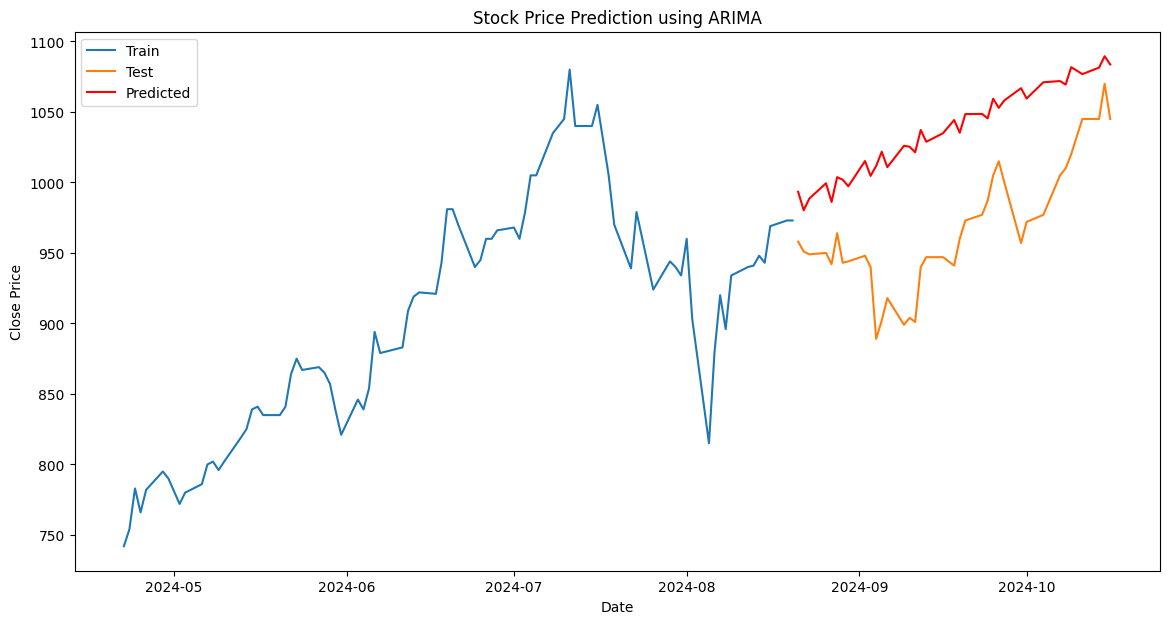

In [160]:
# 繪製折線圖
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, predicted, color='red', label='Predicted')
plt.title('Stock Price Prediction using ARIMA')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

#量化交易策略 -- 均值回歸策略

In [161]:
import yfinance as yf # yahoo finance 套件
import pandas as pd # 結構化資料處理套件
import datetime as dt # 時間套件
import matplotlib.pyplot as plt

In [162]:
# 輸入股票代號
stock_id = "2330.tw"

start = dt.datetime(2020, 1, 1)  # 指定的開始日期
end = dt.datetime(2024, 1, 1)

# 參數1: 股票代號, 參數2: 開始時間, 參數3: 結束時間
data = yf.download(stock_id, start=start, end=end).reset_index()

data['Date'] = pd.to_datetime(data['Date'])

data.set_index('Date', inplace=True)

data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,332.5,339.0,332.5,339.0,306.430176,31754120
2020-01-03,344.0,345.0,335.5,339.5,306.882080,41811268
2020-01-06,333.0,334.5,332.0,332.0,300.102722,45343057
2020-01-07,332.5,333.0,326.5,329.5,297.842926,50879181
2020-01-08,325.0,333.0,325.0,329.5,297.842926,37567748
...,...,...,...,...,...,...
2023-12-25,582.0,585.0,580.0,581.0,573.515503,9548143
2023-12-26,583.0,586.0,582.0,586.0,578.451172,16094308
2023-12-27,587.0,592.0,586.0,592.0,584.373779,33401336


In [163]:
# 計算短期和長期移動平均線
short_window = 20  # 短期移動平均線
long_window = 50   # 長期移動平均線

data['Short_MA'] = data['Close'].rolling(window=short_window).mean()
data['Long_MA'] = data['Close'].rolling(window=long_window).mean()

# 初始化信號
data['Signal'] = 0

# 計算交叉點及生成信號
for i in range(1, len(data)):
    if data['Short_MA'].iloc[i] > data['Long_MA'].iloc[i] and data['Short_MA'].iloc[i-1] <= data['Long_MA'].iloc[i-1]:
        # 短期MA從下方突破長期MA（黃金交叉）
        if (data['Short_MA'].iloc[i-short_window:i] < data['Long_MA'].iloc[i-short_window:i]).all():
            data['Signal'].iloc[i] = 1  # 買入信號
    elif data['Short_MA'].iloc[i] < data['Long_MA'].iloc[i] and data['Short_MA'].iloc[i-1] >= data['Long_MA'].iloc[i-1]:
        # 短期MA從上方跌破長期MA（死亡交叉）
        if (data['Short_MA'].iloc[i-short_window:i] > data['Long_MA'].iloc[i-short_window:i]).all():
            data['Signal'].iloc[i] = -1  # 賣出信號

# 將信號進行移位以計算持倉
data['Position'] = data['Signal'].shift()

In [164]:
# 回測

# 資產淨值初始化
initial_capital = 10000
positions = pd.DataFrame(index=data.index).fillna(0.0)

# 計算持倉的股票數
positions['Stock'] = data['Position'] * 100  # 每次交易100股

# 計算每個時間點持有的股票價值
portfolio = positions.multiply(data['Close'], axis=0)
pos_diff = positions.diff()

# 計算持有的股票價值
portfolio['Holdings'] = positions.multiply(data['Close'], axis=0).sum(axis=1)
portfolio['Cash'] = initial_capital - (pos_diff.multiply(data['Close'], axis=0)).sum(axis=1).cumsum()
portfolio['Total'] = portfolio['Cash'] + portfolio['Holdings']


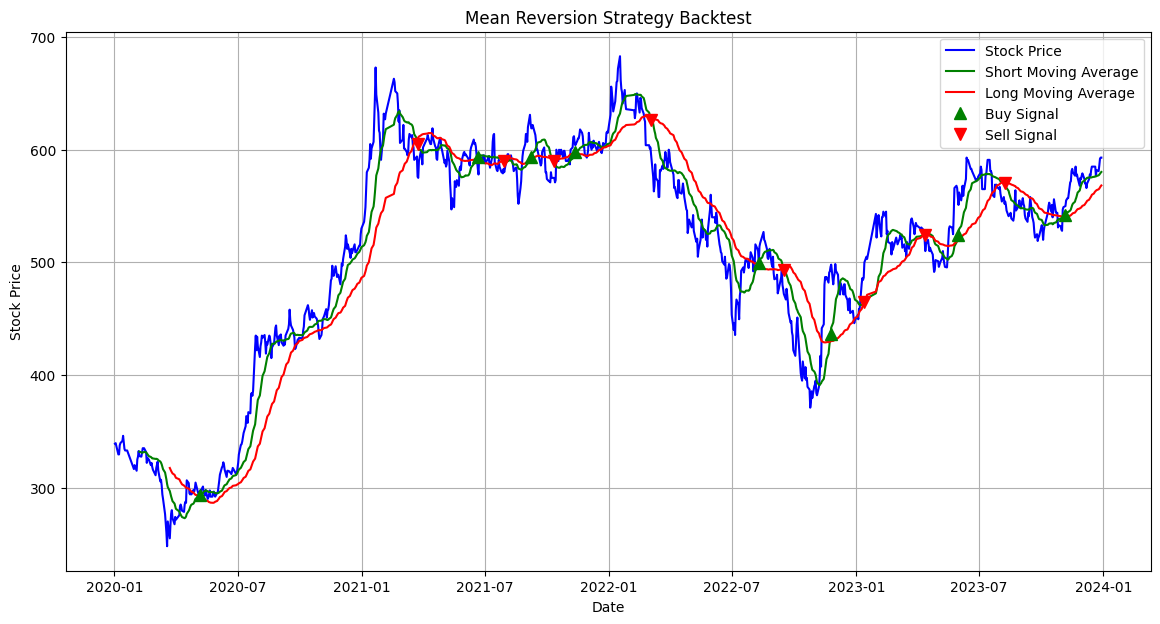

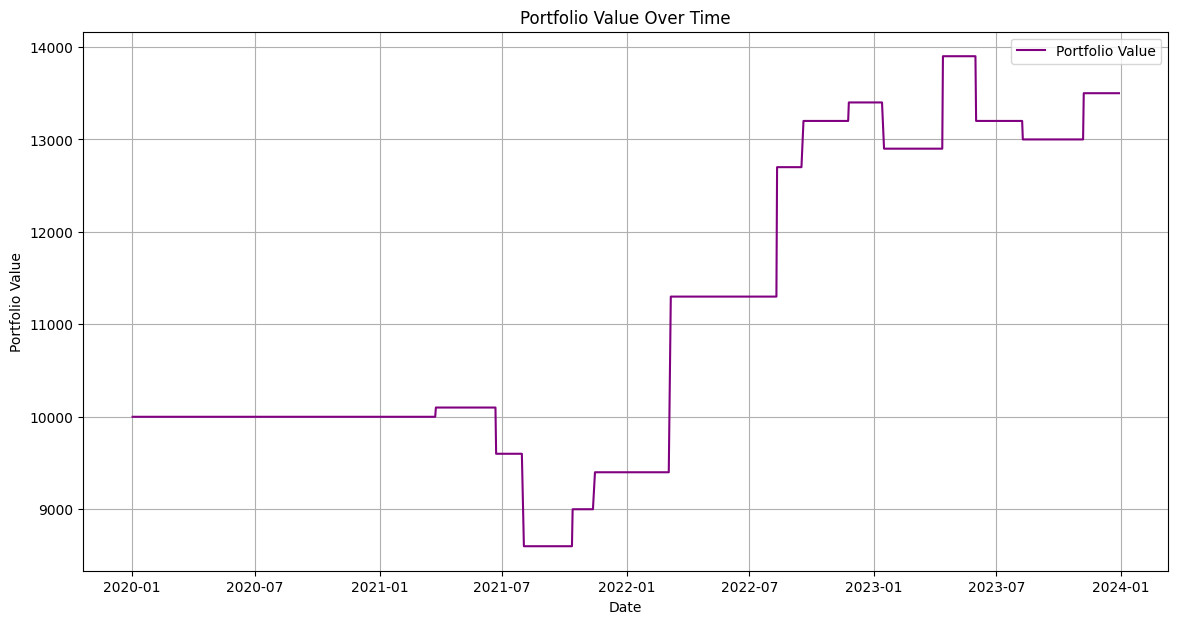

In [165]:
# 繪製策略結果
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Stock Price', color='blue')
plt.plot(data['Short_MA'], label='Short Moving Average', color='green')
plt.plot(data['Long_MA'], label='Long Moving Average', color='red')

# 標註買賣點，使用交叉點的索引
buy_signals = data[data['Signal'] == 1]
sell_signals = data[data['Signal'] == -1]

# 標註買賣點
plt.plot(data[data['Position'] == 1].index,
          data['Short_MA'][data['Position'] == 1],
          '^', markersize=8, color='g', lw=0, label='Buy Signal')

plt.plot(data[data['Position'] == -1].index,
          data['Short_MA'][data['Position'] == -1],
          'v', markersize=8, color='r', lw=0, label='Sell Signal')

plt.title('Mean Reversion Strategy Backtest')
plt.xlabel('Date')  # x 軸標籤
plt.ylabel('Stock Price')  # y 軸標籤
plt.legend(loc='best')
plt.grid(True)
plt.show()

# 繪製資產淨值曲線
plt.figure(figsize=(14, 7))
plt.plot(portfolio['Total'], label='Portfolio Value', color='purple')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')  # x 軸標籤
plt.ylabel('Portfolio Value')  # y 軸標籤
plt.legend(loc='best')
plt.grid(True)
plt.show()